# Self-Organising Maps

In [27]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines

from our_som1A import SOM

In [28]:
# reading data
data = pd.read_csv("cash-crops-nepal.csv")
# visualize some data
data.iloc[:10,:]

,Year AD,Year BS,Crop,Area,Production,Yield
0,1984/85,2041/42,OILSEED,127820,84030,657
1,1985/86,2042/43,OILSEED,137920,78390,568
2,1986/87,2043/44,OILSEED,142890,82500,577
3,1987/88,2044/45,OILSEED,151490,94370,623
4,1988/89,2045/46,OILSEED,154860,99190,641
5,1989/90,2046/47,OILSEED,153660,98060,638
6,1990/91,2047/48,OILSEED,156310,92140,589
7,1991/92,2048/49,OILSEED,154570,87840,568
8,1992/93,2049/50,OILSEED,165240,93690,567
9,1993/94,2050/51,OILSEED,177486,107535,606


In [29]:
data.shape

(105, 6)

In [30]:
# What are the different crops
print(data.iloc[:,2].unique())

['OILSEED' 'POTATO' 'TOBACCO' 'SUGARCANE' 'JUTE']


We will not use "Crop" labels for training SOM. But we will use it to check if the clustering by SOM worked fine or not. We will also drop the “Year AD” and “Year BS” columns.

In [31]:
# shuffling data
agri_data = data.iloc[np.random.permutation(len(data))]
trunc_data = agri_data[["Area", "Production", "Yield"]]
trunc_data.iloc[:10,:]

,Area,Production,Yield
5,153660,98060,638
32,106000,898350,8475
87,14450,15800,1093
89,13000,16000,1231
51,6742,6223,923
43,8680,4680,539
93,9000,11000,1222
100,11289,16392,1452
73,43583,1469214,33711
37,129019,1313717,10182


In [32]:
# (custom choice for) normalizing data
trunc_data = trunc_data / trunc_data.max()
trunc_data.iloc[:10,:]

,Area,Production,Yield
5,0.806915,0.041269,0.015864
32,0.556638,0.378077,0.210732
87,0.075881,0.006650,0.027178
89,0.068267,0.006734,0.030609
51,0.035404,0.002619,0.022950
43,0.045581,0.001970,0.013402
93,0.047262,0.004629,0.030385
100,0.059282,0.006899,0.036104
73,0.228867,0.618329,0.838228
37,0.677518,0.552887,0.253177


## Training SOM

Now let’s train the data in a 3 x 3 SOM network using 3 input features. 

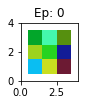

In [33]:
# som = SOM(x_size, y_size, num_features)
agri_som = SOM(3,3,3)

# Initial weights
init_fig = plt.figure()
agri_som.show_plot(init_fig, 1, 0)
plt.show()

Random weights (3 features) are given to each of 9 (3×3) neurons. The above figure shows how the neural network looks like in the beginning.

Notice: 

- after 60 Epochs, the network changed from random colors (initialization) to nearly constant color; this means that initial neighbourhood is large, so each neuron’s weight are being adjusted according to data.

- Slowly, the network develops different color according to input data structures/patterns, but, you can notice similar colors are neighbors to one another.

- Since there was a random initialization, the positions of colors may change but the topology will be preserved.

## Prediction and Analysis

In [34]:
def predict(df, agri_som):
    """
    finds the Best Matching Unit for each data sample.
    Thus, the neuron with closest distance from data sample.
    
    Args:
        df (pd.DataFrame): df to be updated
        agri_som (obj): model

    Returns:
        pd.DataFrame: updated df
    """
    bmu, bmu_idx = agri_som.find_bmu(df.values)
    df['bmu'] = bmu
    df['bmu_idx'] = bmu_idx
    return df


In [35]:
def arrange_data(agri_som):
    """
    Fetch BMU of data samples and append them to the filtered agri_dataset    

    Args:
        agri_som (object): SOM model

    Returns:
        pd.DataFrame: updated agri_data with BMU
    """
    clustered_df = trunc_data.apply(predict, axis=1, agri_som=agri_som)
    joined_df = agri_data.join(clustered_df, rsuffix="_norm")
    return joined_df

In [36]:
def external_purity(df):
    """Purity measures the purity of clusters with respect to ground-truth class labels. To compute the purity of a clustering Q, 
    each cluster is assigned to the class which is most frequent in the cluster, and then the accuracy of this assignment is measured 
    by counting the number of correctly assigned points and dividing by the total number of points:

    Prospers Comment:
        with this implementation, the computation of the total_correct includes classes located in multiple clusters. 
        For instance, if POTATO is located in [0,0] with count of 20, and also located in [2,2] with count of 40, both instances are 
        included in the computation of the total_correct. But with the definition, POTATO will be assigned to the cluster [2,2] and 
        not [0,0] also, so computation will include only 40 for 'POTATO'. Kindly verify that.
        For this reason, I implemented a proposed edition tagged 'prospers_purity' correcting this error.

    Args:
        df (pd.DataFrame): joined training set with bmu positions and weights
    """
    classes = [str(i) for i in df.bmu_idx.tolist()]  # all neurons/clusters responsible each data point
    classes_uniq = set(classes)  # unique neurons (<= 9 since 3*3 grid. less if some neuron(s) dont have any samples)
    clusters = {i:{} for i in classes_uniq}  # build associative array to hold all samples for each neuron.

    data = [[str(i),j] for i,j in zip(df.bmu_idx.tolist(), df.Crop)]
    for i in classes_uniq:
        for j in data:
            exact= j[0]
            pred = j[1]
            if exact == i:
                if pred not in clusters[exact].keys():
                    clusters[exact][pred] = 1
                else:
                    clusters[exact][pred] += 1
    total_correct = 0
    total = len(data)
    for cluster in clusters.values():
        total_correct += max(cluster.values())
    
    return total_correct/total


def prospers_purity(df):
    """Implemented to correct the over summand error in the above implementation
    """
    # proper representation of column
    df['bmu_idx'] = df['bmu_idx'].apply(lambda k: str(k))
    df['bmu'] = df['bmu'].apply(lambda k: k[0])

    # fetch number of different samples associated to each cluster.
    clusters = df.value_counts(subset=['Crop', 'bmu_idx']).reset_index() 
    clusters.rename(columns={0:'count'}, inplace=True)

    total = np.sum(clusters['count'])  # compute total number of points

    # assign class which is most frequent in the cluster. highest count of that specific crop type in cluster
    cluster_dominated = clusters.groupby(by=['Crop']).max().reset_index()
    total_correct = np.sum(cluster_dominated['count'])  # compute total number of correctly clustered
    
    return total_correct/total

    

def cluster_accuracy(df):
    """
    The cluster accuracy as specified in the reference is the number of samples assigned to the correct class divided by the total 
    number of samples. It can also be used in clustering as an external quality measure if labels are available and if 
    the number of clusters is equal to the number of classes (which is not our case, yet, I tried implementing). ...

    Comments:
        The cluster matrix was sparse leading to obtaining non-optimal result using the hungarian method which sought to 
        minimize the sum function. You can verify that with the below implementation.
    """
    from scipy.optimize import linear_sum_assignment  # for hungarian optimization

    # representing df in a proper format
    df['bmu_idx'] = df['bmu_idx'].apply(lambda k: str(k))
    df['bmu'] = df['bmu_idx'].apply(lambda k: k[0])

    # fetch classes and unique classes
    unique_classes = df['bmu_idx'].apply(lambda k: str(k)).unique()
    classes = df['bmu'].apply(lambda k: str(k[0])).unique()

    # compute the cluster matrix to minimize sum
    cost = df.pivot_table(index='Crop', columns='bmu_idx', values='Area', aggfunc='count', fill_value=0)

    row_ind, col_ind = linear_sum_assignment(cost)  # optimal locations

    cost.values[row_ind, col_ind].sum()  # optimal locations result to 0 sum.

In [37]:
def visualize(joined_df, lr, lf,agri_som):
    fig = plt.figure()
    # setup axes
    ax = fig.add_subplot(111)
    scale = 50
    ax.set_xlim((0, agri_som.net.shape[0]*scale))
    ax.set_ylim((0, agri_som.net.shape[1]*scale))
    ax.set_title("learning function: "+lf+", learning rate: "+str(lr))

    for x in range(0, agri_som.net.shape[0]):
        for y in range(0, agri_som.net.shape[1]):
            ax.add_patch(patches.Rectangle((x*scale, y*scale), scale, scale,
                         facecolor='white',
                         edgecolor='grey'))
    legend_map = {}

    for index, row in joined_df.iterrows():
        x_cor = row['bmu_idx'][0] * scale
        y_cor = row['bmu_idx'][1] * scale
        x_cor = np.random.randint(x_cor, x_cor + scale)
        y_cor = np.random.randint(y_cor, y_cor + scale)
        color = row['bmu'][0]
        marker = "$\\ " + row['Crop'][0]+"$"
        marker = marker.lower()
        ax.plot(x_cor, y_cor, color=color, marker=marker, markersize=10)
        label = row['Crop']
        if not label in legend_map:
            legend_map[label] =  mlines.Line2D([], [], color='black', marker=marker, linestyle='None',
                              markersize=10, label=label)
    plt.legend(handles=list(legend_map.values()), bbox_to_anchor=(1, 1))
    plt.show()

In [38]:
"""
executes SOM for epochs [10, 50, 100, 300, 400, 500]
"""

external_purities_10 = []
prospers_purities_10 = []
def run_10(base_lr, lr_decay_function, show_plot=False):
    """wrapper function for 10 epochs. implements the SOM with the given parameters

    Args:
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.train(trunc_data.values,
          num_epochs=10,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_10.append(external_purity(joined_df))
    prospers_purities_10.append(prospers_purity(joined_df))


external_purities_50 = []
prospers_purities_50 = []
def run_50(base_lr, lr_decay_function, show_plot=False):
    """wrapper function for 50 epochs. implements the SOM with the given parameters

    Args:
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.train(trunc_data.values,
          num_epochs=50,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_50.append(external_purity(joined_df))
    prospers_purities_50.append(prospers_purity(joined_df))


external_purities_100 = []
prospers_purities_100 = []
def run_100(base_lr, lr_decay_function, show_plot=False):
    """wrapper function for 100 epochs. implements the SOM with the given parameters

    Args:
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.train(trunc_data.values,
          num_epochs=100,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_100.append(external_purity(joined_df))
    prospers_purities_100.append(prospers_purity(joined_df))


external_purities_300 = []
prospers_purities_300 = []
def run_300(base_lr, lr_decay_function, show_plot=False):
    """wrapper function for 300 epochs. implements the SOM with the given parameters

    Args:
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.train(trunc_data.values,
          num_epochs=300,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_300.append(external_purity(joined_df))
    prospers_purities_300.append(prospers_purity(joined_df))


external_purities_400 = []
prospers_purities_400 = []
def run_400(base_lr, lr_decay_function, show_plot=False):
    """wrapper function for 400 epochs. implements the SOM with the given parameters

    Args:
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.train(trunc_data.values,
          num_epochs=400,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_400.append(external_purity(joined_df))
    prospers_purities_400.append(prospers_purity(joined_df))


external_purities_500 = []
prospers_purities_500 = []
def run_500(base_lr, lr_decay_function, show_plot=False):
    """wrapper function for 500 epochs. implements the SOM with the given parameters

    Args:
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.train(trunc_data.values,
          num_epochs=500,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_500.append(external_purity(joined_df))
    prospers_purities_500.append(prospers_purity(joined_df))


In [39]:
# More rates, and decay functions can be appended. cost is running time
lrs = [1, 0.1, 0.01, 0.001]  # base learning rates
lfs = ["default", "linear", "inverse", "power"]  # learning rate decay functions

# 16 runs/combinations in all
mesh = np.array(np.meshgrid(lrs, lfs))
lrs_lfs = mesh.T.reshape(-1, 2)

for lr, lf in lrs_lfs:
    lr = lr.astype('float64')
    run_10(base_lr=lr, lr_decay_function=lf, show_plot=False)
    run_50(base_lr=lr, lr_decay_function=lf, show_plot=False)
    run_100(base_lr=lr, lr_decay_function=lf, show_plot=False)
    run_300(base_lr=lr, lr_decay_function=lf, show_plot=False)
    run_400(base_lr=lr, lr_decay_function=lf, show_plot=False)
    run_500(base_lr=lr, lr_decay_function=lf, show_plot=False)

    print(f'{lr}_{lf} done!')

1.0_default done!
1.0_linear done!
1.0_inverse done!
1.0_power done!
0.1_default done!
0.1_linear done!
0.1_inverse done!
0.1_power done!
0.01_default done!
0.01_linear done!
0.01_inverse done!
0.01_power done!
0.001_default done!
0.001_linear done!
0.001_inverse done!
0.001_power done!


### **Analyzing Results**

In [40]:
# extract columns
lrs_ = [_[0] for _ in lrs_lfs]
lfs_ = [_[1] for _ in lrs_lfs]

data = {
	'learning_function': lfs_,
	'learning_rate': lrs_,
	'external_purities_10': external_purities_10, 
	'prosper_p10': prospers_purities_10, 
	'external_p50': external_purities_50, 
	'prosper_p50': prospers_purities_50,
	'external_p100': external_purities_100,
	'prosper_p100': prospers_purities_100,
	'external_p300': external_purities_300, 
	'prosper_p300': prospers_purities_300,
	'external_p400': external_purities_400, 
	'prosper_p400': prospers_purities_400,
	'external_p500': external_purities_500,
	'prosper_p500': prospers_purities_500,
}
results_df = pd.DataFrame(
	data, index=range(1, len(lrs_)+1)
)

results_df.head()

,learning_function,learning_rate,external_purities_10,prosper_p10,external_p50,prosper_p50,external_p100,prosper_p100,external_p300,prosper_p300,external_p400,prosper_p400,external_p500,prosper_p500
1,default,1.0,0.809524,0.885714,0.809524,0.876190,0.80000,0.866667,0.780952,0.828571,0.809524,0.876190,0.961905,0.847619
2,linear,1.0,0.800000,0.847619,0.800000,0.857143,0.80000,0.857143,0.800000,0.857143,0.800000,0.857143,0.800000,0.857143
3,inverse,1.0,0.809524,0.857143,0.800000,0.800000,0.87619,0.657143,0.819048,0.809524,0.933333,0.723810,0.800000,0.923810
4,power,1.0,0.809524,0.866667,0.800000,0.857143,0.80000,0.857143,0.800000,0.857143,0.800000,0.857143,0.800000,0.857143
5,default,0.1,0.800000,0.761905,0.800000,0.857143,0.80000,0.857143,0.800000,0.857143,0.800000,0.847619,0.800000,0.847619


In [41]:
# temp cell
results_df = results_df[['learning_function', 'learning_rate'] + [_ for _ in results_df.columns if _.startswith('p')]]

In [46]:
results_df.head()

,learning_function,learning_rate,prosper_p10,prosper_p50,prosper_p100,prosper_p300,prosper_p400,prosper_p500
1,default,1.0,0.885714,0.876190,0.866667,0.828571,0.876190,0.847619
2,linear,1.0,0.847619,0.857143,0.857143,0.857143,0.857143,0.857143
3,inverse,1.0,0.857143,0.800000,0.657143,0.809524,0.723810,0.923810
4,power,1.0,0.866667,0.857143,0.857143,0.857143,0.857143,0.857143
5,default,0.1,0.761905,0.857143,0.857143,0.857143,0.847619,0.847619


In [43]:
# Descriptive statistics
results_df.describe()

,prosper_p10,prosper_p50,prosper_p100,prosper_p300,prosper_p400,prosper_p500
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.832738,0.849405,0.826190,0.828571,0.841071,0.835714
std,0.032986,0.023642,0.055478,0.039955,0.046230,0.046462
min,0.761905,0.790476,0.657143,0.742857,0.723810,0.723810
25%,0.819048,0.854762,0.811905,0.795238,0.847619,0.821429
50%,0.838095,0.857143,0.852381,0.857143,0.857143,0.852381
75%,0.857143,0.857143,0.857143,0.857143,0.859524,0.857143
max,0.885714,0.876190,0.876190,0.866667,0.885714,0.923810


In [48]:
# Highest Accuracies
"""
Maximum Accuracy:
	- inverse learning function (1.0, 0.1) learning rates at 500 epochs 93%
	- default function, 1.0 learning rate. 10 epochs, 89%.
	- power function, 0.001 learning rate, 400 epochs, 89%/.

"""
maxs = results_df.iloc[:,2:].idxmax().reset_index()
maxs.rename(columns={'index': 'column', 0: 'row'}, inplace=True)
max_rows = maxs['row'].values

# maximum rows for each epochs.
results_df[results_df.index.isin(max_rows)]

,learning_function,learning_rate,prosper_p10,prosper_p50,prosper_p100,prosper_p300,prosper_p400,prosper_p500
1,default,1.0,0.885714,0.876190,0.866667,0.828571,0.876190,0.847619
3,inverse,1.0,0.857143,0.800000,0.657143,0.809524,0.723810,0.923810
7,inverse,0.1,0.819048,0.857143,0.847619,0.866667,0.847619,0.847619
12,power,0.01,0.771429,0.857143,0.876190,0.800000,0.733333,0.771429
16,power,0.001,0.838095,0.857143,0.819048,0.742857,0.885714,0.857143


In [45]:
# Minimum
"""
Minimum Accuracy:
	- inverse function, 1.0 learning rate, 100 epochs, 66%.
"""
mins = results_df.iloc[:,2:].idxmin().reset_index()
mins.rename(columns={'index': 'column', 0: 'row'}, inplace=True)
min_rows = mins['row'].values

# table of maximums by inspection from description, our best shot is row 12
results_df[results_df.index.isin(min_rows)]

,learning_function,learning_rate,prosper_p10,prosper_p50,prosper_p100,prosper_p300,prosper_p400,prosper_p500
3,inverse,1.0,0.857143,0.800000,0.657143,0.809524,0.723810,0.923810
5,default,0.1,0.761905,0.857143,0.857143,0.857143,0.847619,0.847619
13,default,0.001,0.800000,0.790476,0.838095,0.857143,0.866667,0.857143
14,linear,0.001,0.838095,0.828571,0.790476,0.780952,0.857143,0.723810
16,power,0.001,0.838095,0.857143,0.819048,0.742857,0.885714,0.857143


### **Individual Performance**

In [50]:
# default
"""
- overall accuracy decreases with smaller learning rates.
- performance increases for larger epochs

"""
results_df[results_df['learning_function'] == 'default']

,learning_function,learning_rate,prosper_p10,prosper_p50,prosper_p100,prosper_p300,prosper_p400,prosper_p500
1,default,1.0,0.885714,0.876190,0.866667,0.828571,0.876190,0.847619
5,default,0.1,0.761905,0.857143,0.857143,0.857143,0.847619,0.847619
9,default,0.01,0.819048,0.857143,0.866667,0.857143,0.857143,0.857143
13,default,0.001,0.800000,0.790476,0.838095,0.857143,0.866667,0.857143


In [51]:
# linear
"""
- overall accuracy decreases for smaller learning rates.
- accuracy decreases for larger epochs.
- not a good function.
"""
results_df[results_df['learning_function'] == 'linear']

,learning_function,learning_rate,prosper_p10,prosper_p50,prosper_p100,prosper_p300,prosper_p400,prosper_p500
2,linear,1.0,0.847619,0.857143,0.857143,0.857143,0.857143,0.857143
6,linear,0.1,0.857143,0.857143,0.857143,0.857143,0.857143,0.800000
10,linear,0.01,0.857143,0.847619,0.857143,0.780952,0.847619,0.780952
14,linear,0.001,0.838095,0.828571,0.790476,0.780952,0.857143,0.723810


In [52]:
# inverse
"""
- overall accuracy increases for smaller learning rates but not for very very small rates (0.001)
- accuracy increases across larger epochs.
- a good function.
"""
results_df[results_df['learning_function'] == 'inverse']

,learning_function,learning_rate,prosper_p10,prosper_p50,prosper_p100,prosper_p300,prosper_p400,prosper_p500
3,inverse,1.0,0.857143,0.800000,0.657143,0.809524,0.723810,0.923810
7,inverse,0.1,0.819048,0.857143,0.847619,0.866667,0.847619,0.847619
11,inverse,0.01,0.838095,0.857143,0.771429,0.857143,0.857143,0.857143
15,inverse,0.001,0.838095,0.876190,0.780952,0.780952,0.866667,0.857143


In [53]:
# power
"""
- overall accuracy decreases for smaller learning rates.
- accuracy increases across larger epochs.
- not a good function.
"""
results_df[results_df['learning_function'] == 'power']

,learning_function,learning_rate,prosper_p10,prosper_p50,prosper_p100,prosper_p300,prosper_p400,prosper_p500
4,power,1.0,0.866667,0.857143,0.857143,0.857143,0.857143,0.857143
8,power,0.1,0.828571,0.857143,0.819048,0.866667,0.819048,0.828571
12,power,0.01,0.771429,0.857143,0.876190,0.800000,0.733333,0.771429
16,power,0.001,0.838095,0.857143,0.819048,0.742857,0.885714,0.857143
